In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import keras

2025-03-07 10:30:07.996347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load LOBSTER Sample Dataset

In [3]:
def import_orderbook(
    filedir: str = 'orderbook/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv') -> Tuple[np.ndarray, pd.DataFrame]:
    '''
    '''
    ob = pd.read_csv(filedir, header=None).values.astype(float)
    ob[:,0::2]=(ob[:,0::2] / 1e4)
    N = ob.shape[1]
    columns_list = []
    for i in range(int(N/4)):
        columns_list.extend([f'Ask_Price_{i+1}', f'Ask_Size_{i+1}', f'Bid_Price_{i+1}', f'Bid_Size_{i+1}'])
    df_ob = pd.DataFrame(ob, columns=columns_list)
    return ob, df_ob

def import_message(
    filedir: str = 'orderbook/AMZN_2012-06-21_34200000_57600000_message_10.csv') -> Tuple[np.ndarray, pd.DataFrame]:
    '''
    '''
    msg = pd.read_csv(filedir, header=None).values
    columns_list = ['Time', 'Type', 'Order_ID', 'Size', 'Price', 'Direction']
    int_columns_list = ['Type', 'Order_ID', 'Size', 'Price', 'Direction']
    df_msg = pd.DataFrame(msg, columns=columns_list)
    df_msg[int_columns_list] = df_msg[int_columns_list].astype('int')
    return msg, df_msg
    

In [4]:
orderbook, df_orderbook = import_orderbook()
message, df_message = import_message()

In [5]:
df_orderbook.head()

,Ask_Price_1,Ask_Size_1,Bid_Price_1,Bid_Size_1,Ask_Price_2,Ask_Size_2,Bid_Price_2,Bid_Size_2,Ask_Price_3,Ask_Size_3,...,Bid_Price_8,Bid_Size_8,Ask_Price_9,Ask_Size_9,Bid_Price_9,Bid_Size_9,Ask_Price_10,Ask_Size_10,Bid_Price_10,Bid_Size_10
0,223.95,100.0,223.18,100.0,223.99,100.0,223.07,200.0,224.00,220.0,...,220.25,5000.0,229.43,100.0,220.20,100.0,229.80,100.0,218.97,100.0
1,223.95,100.0,223.81,21.0,223.99,100.0,223.18,100.0,224.00,220.0,...,220.40,100.0,229.43,100.0,220.25,5000.0,229.80,100.0,220.20,100.0
2,223.95,100.0,223.81,21.0,223.96,20.0,223.18,100.0,223.99,100.0,...,220.40,100.0,226.77,100.0,220.25,5000.0,229.43,100.0,220.20,100.0
3,223.95,100.0,223.81,21.0,223.96,20.0,223.75,100.0,223.99,100.0,...,221.30,4000.0,226.77,100.0,220.40,100.0,229.43,100.0,220.25,5000.0
4,223.95,100.0,223.81,21.0,223.96,20.0,223.75,100.0,223.99,100.0,...,221.30,4000.0,226.77,100.0,220.40,100.0,229.43,100.0,220.25,5000.0


In [6]:
df_message.head()

,Time,Type,Order_ID,Size,Price,Direction
0,34200.017460,5,0,1,2238200,-1
1,34200.189608,1,11885113,21,2238100,1
2,34200.189608,1,3911376,20,2239600,-1
3,34200.189608,1,11534792,100,2237500,1
4,34200.189608,1,1365373,13,2240000,-1


## Data Visualisation

In [8]:
# Constants
TICKER = 'AAPL'
START_TRAD = 9.5 * 60 * 60  # Start of Trading hours, 9:30:00 in seconds
END_TRAD = 16 * 60 * 60     # End of Trading hours, 16:00:00 in seconds
FREQ = 5 * 60               # 5 minutes in seconds
NOINT = int((END_TRAD - START_TRAD) / FREQ)  # Number of intervals

# Filter data within trading hours
df_message_trad = df_message[(df_message['Time'] >= START_TRAD) & (df_message['Time'] <= END_TRAD)].copy()
df_orderbook_trad = df_orderbook.loc[df_message_trad.index]

### 1. Number of Executions and Volume of Trades by Interval

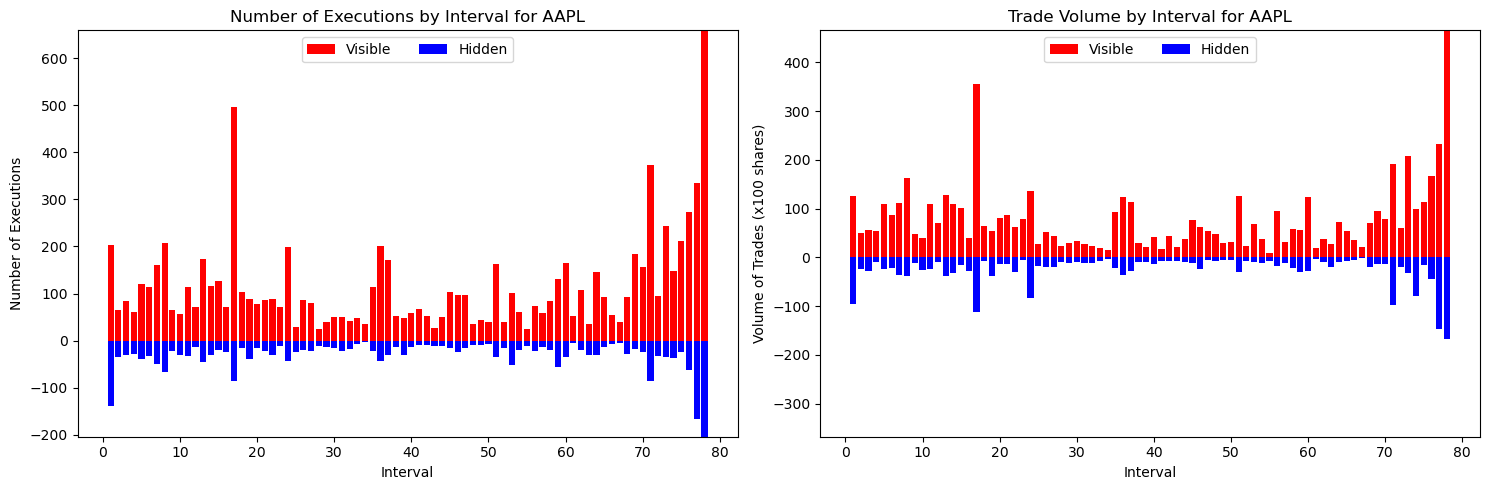

In [10]:
def plot_executions_and_volume():
    bounds = np.linspace(START_TRAD, END_TRAD, NOINT + 1)
    
    # Calculate counts and sizes
    visible_count = []
    hidden_count = []
    visible_size = []
    hidden_size = []
    
    for i in range(NOINT):
        mask_visible = (df_message_trad['Time'] > bounds[i]) & (df_message_trad['Time'] < bounds[i+1]) & (df_message_trad['Type'] == 4)
        mask_hidden = (df_message_trad['Time'] > bounds[i]) & (df_message_trad['Time'] < bounds[i+1]) & (df_message_trad['Type'] == 5)
        
        visible_count.append(mask_visible.sum())
        hidden_count.append(mask_hidden.sum())
        visible_size.append(df_message_trad.loc[mask_visible, 'Size'].sum() / 100)
        hidden_size.append(df_message_trad.loc[mask_hidden, 'Size'].sum() / 100)
    
    x = np.arange(1, NOINT + 1)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Number of Executions
    ax1.bar(x, visible_count, color='red', width=0.8, label='Visible')
    ax1.bar(x, [-x for x in hidden_count], color='blue', width=0.8, label='Hidden')
    ax1.set_ylim(-max(hidden_count), max(visible_count))
    ax1.set_ylabel('Number of Executions')
    ax1.set_xlabel('Interval')
    ax1.set_title(f'Number of Executions by Interval for {TICKER}')
    ax1.legend(loc='upper center', ncol=2)
    
    # Plot 2: Trade Volume
    ax2.bar(x, visible_size, color='red', width=0.8, label='Visible')
    ax2.bar(x, [-x for x in hidden_size], color='blue', width=0.8, label='Hidden')
    ax2.set_ylim(-max(hidden_size)-200, max(visible_size))
    ax2.set_ylabel('Volume of Trades (x100 shares)')
    ax2.set_xlabel('Interval')
    ax2.set_title(f'Trade Volume by Interval for {TICKER}')
    ax2.legend(loc='upper center', ncol=2)
    
    plt.tight_layout()
    plt.show()

plot_executions_and_volume()

### 2. Limit Order Book Snapshot

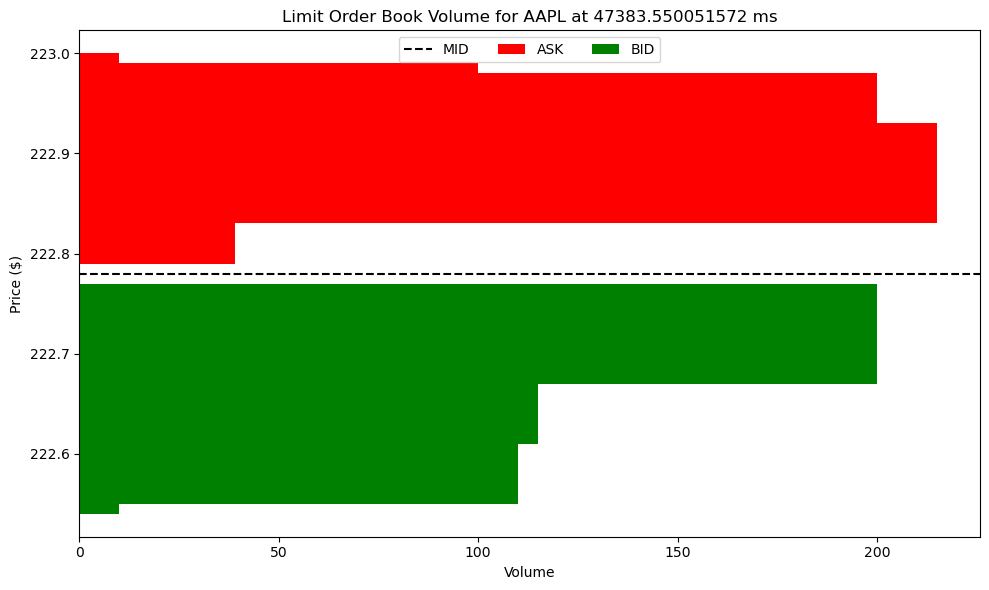

In [12]:
def plot_lob_snapshot(snapshot_time=None):
    if snapshot_time == None:
        snapshot_time = np.random.randint(0, len(df_orderbook_trad))
    prices = df_orderbook_trad.iloc[snapshot_time, 0::2].values
    sizes = df_orderbook_trad.iloc[snapshot_time, 1::2].values
    
    # Separate ask and bid data
    ask_prices = prices[0::2]  # Ask prices are in even indices
    bid_prices = prices[1::2]  # Bid prices are in odd indices
    ask_sizes = sizes[0::2]
    bid_sizes = sizes[1::2]
    
    # Calculate mid price
    mid_price = (ask_prices[0] + bid_prices[0]) / 2
    
    plt.figure(figsize=(10, 6))
    
    # Plot Ask side (red)
    plt.barh(ask_prices, ask_sizes, color='red', height=0.1, label='ASK')
    
    # Plot Bid side (green)
    plt.barh(bid_prices, bid_sizes, color='green', height=0.1, label='BID')
    
    # Add horizontal dashed line at mid price
    plt.axhline(y=mid_price, color='black', linestyle='--', linewidth=1.5, label='MID')
    
    plt.ylabel('Price ($)')
    plt.xlabel('Volume')
    plt.title(f'Limit Order Book Volume for {TICKER} at {df_message_trad.iloc[snapshot_time]['Time']} ms')
    plt.legend(loc='upper center', ncol=3)  # Adjusted ncol to accommodate new label
    plt.tight_layout()
    plt.show()

plot_lob_snapshot()

### 3. Limit Order Book Relative Depth

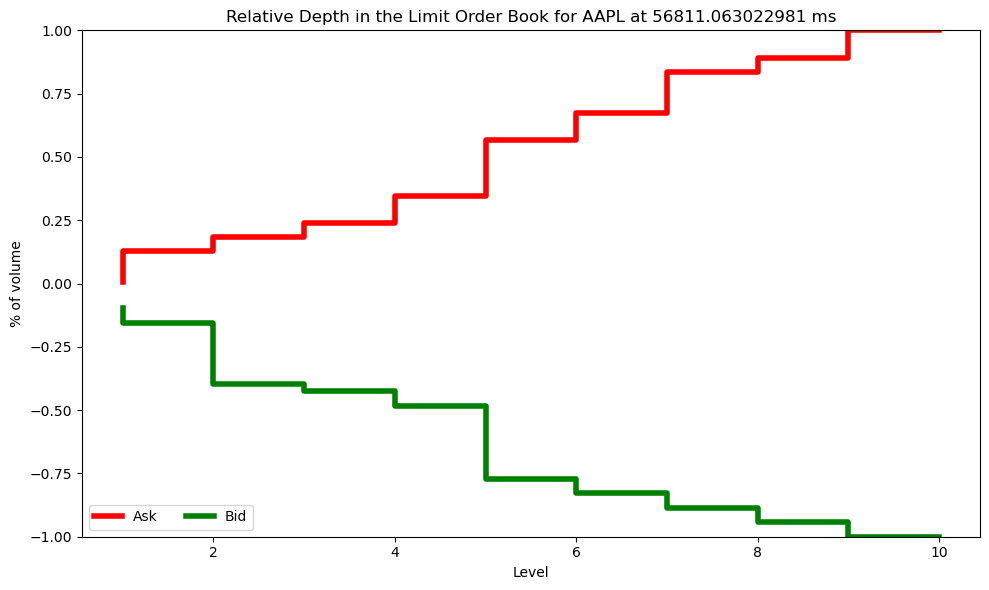

In [14]:
def plot_relative_depth(snapshot_time=None):
    if snapshot_time == None:
        snapshot_time = np.random.randint(0, len(df_orderbook_trad))
    sizes = df_orderbook_trad.iloc[snapshot_time, 1::2].values
    nlevels = int(len(sizes) / 2)
    
    ask_sizes = sizes[0::2]
    bid_sizes = sizes[1::2]
    
    perc_ask = np.cumsum(ask_sizes) / np.sum(ask_sizes)
    perc_bid = -np.cumsum(bid_sizes) / np.sum(bid_sizes)
    
    x = np.arange(1, nlevels + 1)
    
    plt.figure(figsize=(10, 6))
    plt.step(x, perc_ask, color='red', linewidth=4, label='Ask')
    plt.step(x, perc_bid, color='green', linewidth=4, label='Bid')
    plt.ylim(-1, 1)
    plt.xlabel('Level')
    plt.ylabel('% of volume')
    plt.title(f'Relative Depth in the Limit Order Book for {TICKER} at {df_message_trad.iloc[snapshot_time]['Time']} ms')
    plt.legend(loc='lower left', ncol=2)
    plt.tight_layout()
    plt.show()

plot_relative_depth()

### 4. Intraday Evolution of Depth

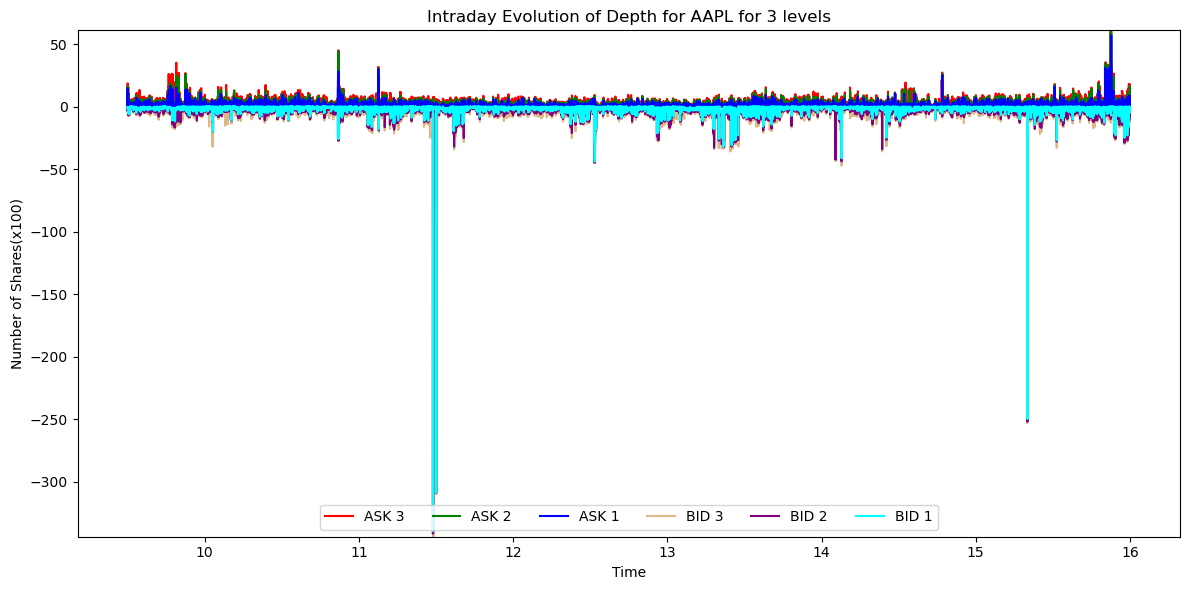

In [16]:
def plot_intraday_depth():
    time_hours = df_message_trad['Time'] / (60 * 60)
    
    # Calculate cumulative volumes
    ask_vol1 = df_orderbook_trad['Ask_Size_1'] / 100
    ask_vol2 = ask_vol1 + df_orderbook_trad['Ask_Size_2'] / 100
    ask_vol3 = ask_vol2 + df_orderbook_trad['Ask_Size_3'] / 100
    
    bid_vol1 = -df_orderbook_trad['Bid_Size_1'] / 100
    bid_vol2 = bid_vol1 - df_orderbook_trad['Bid_Size_2'] / 100
    bid_vol3 = bid_vol2 - df_orderbook_trad['Bid_Size_3'] / 100
    
    max_ask = max(ask_vol3.max(), ask_vol2.max(), ask_vol1.max())
    max_bid = min(bid_vol3.min(), bid_vol2.min(), bid_vol1.min())
    
    plt.figure(figsize=(12, 6))
    
    # Plot ASK levels
    plt.plot(time_hours, ask_vol3, color='red', label='ASK 3')
    plt.plot(time_hours, ask_vol2, color='green', label='ASK 2')
    plt.plot(time_hours, ask_vol1, color='blue', label='ASK 1')
    
    # Plot BID levels
    plt.plot(time_hours, bid_vol3, color='burlywood', label='BID 3')
    plt.plot(time_hours, bid_vol2, color='purple', label='BID 2')
    plt.plot(time_hours, bid_vol1, color='cyan', label='BID 1')
    
    plt.ylim(max_bid, max_ask)
    plt.xlabel('Time')
    plt.ylabel('Number of Shares(x100)')
    plt.title(f'Intraday Evolution of Depth for {TICKER} for 3 levels')
    plt.xticks(range(10, 17))
    plt.legend(loc='lower center', ncol=6)
    plt.tight_layout()
    plt.show()

plot_intraday_depth()

## Preparation of input-output data

In [18]:
# Remove the events that do not have mid price change
def RemoveNoNextPriceChangeEvent(df_orderbook: pd.DataFrame = df_orderbook_trad):
    orderbook = df_orderbook.values 
    midprice = (orderbook[:,0] + orderbook[:,2])/2
    sign_vec = np.sign(midprice[1:] - midprice[:-1])
    index0 = np.where(sign_vec != 0)
    orderbook = orderbook[:-1,:]
    sign_vec = sign_vec[index0[0]] * 0.5 + 0.5
    sign_vec = sign_vec.astype('int')
    label = keras.utils.to_categorical(sign_vec, num_classes=2)
    df_orderbook = df_orderbook.iloc[index0]
    orderbook = df_orderbook.values
    return orderbook, df_orderbook, label

orderbook, df_orderbook, label = RemoveNoNextPriceChangeEvent()

In [19]:
# Prepare the data for the learning algorithm
def P_lagged_data(X, p: int = 1):
    n = X.shape[0]
    LaggedX = np.zeros([n-p, p, X.shape[1]])
    for i in range(n-p):
        LaggedX[i,:,:] = X[i:(i+p),:]
    return LaggedX

def GenerateLaggedValueInputOutput(df_orderbook: pd.DataFrame = df_orderbook,
                                   label: np.ndarray = label,
                                   p: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    orderbook = df_orderbook.values
    inputX = P_lagged_data(orderbook, p)
    outputY = label[p:]
    return inputX, outputY

p = 50
inputX, outputY = GenerateLaggedValueInputOutput(df_orderbook, label, p)

## Split into train/test data and Normalize

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [22]:
X_train, X_test, y_train, y_test = train_test_split(inputX, outputY,
                                                    test_size = 0.1,
                                                    shuffle = False)

In [23]:
def Normalize3D_tensor_Data(X_train: pd.DataFrame = X_train,
                            X_test: pd.DataFrame = X_test):
    dim_train = np.shape(X_train)
    X_train_s = np.zeros(dim_train, dtype = float)
    X_test_s = np.zeros(np.shape(X_test), dtype = float)
    for i in range(dim_train[1]):
        scaler = preprocessing.StandardScaler().fit(X_train[:, i, :])
        X_train_s[:, i, :] = scaler.transform(X_train[:, i, :])
        X_test_s[:, i, :] = scaler.transform(X_test[:, i, :])
    return X_train_s, X_test_s

X_train_scaled, X_test_scaled = Normalize3D_tensor_Data(X_train, X_test)

## LSTM: 1-layer & 3-layer

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential

In [26]:
def lstm(input_shape, nodes, dropout):
    model = Sequential()
    model.add(LSTM(nodes, dropout = dropout, input_shape = input_shape, use_bias = True))
    model.add(Dense(10, activation = 'relu', use_bias = True))
    model.add(Dense(2, activation = 'softmax', use_bias = True))
    adam = keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [metrics.categorical_accuracy])
    return model

In [27]:
model1 = lstm(X_train_scaled.shape[1:], 30, 0.15)
hist1 = model1.fit(X_train_scaled, y_train, validation_split = 0.1, batch_size = 2000, epochs = 50, shuffle = True, verbose = 1)
scores = model1.evaluate(X_test_scaled, y_test, verbose = 1)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - categorical_accuracy: 0.5074 - loss: 0.6968 - val_categorical_accuracy: 0.5586 - val_loss: 0.6918
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - categorical_accuracy: 0.5178 - loss: 0.6932 - val_categorical_accuracy: 0.5057 - val_loss: 0.6933
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - categorical_accuracy: 0.5185 - loss: 0.6925 - val_categorical_accuracy: 0.5691 - val_loss: 0.6886
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - categorical_accuracy: 0.5261 - loss: 0.6908 - val_categorical_accuracy: 0.5792 - val_loss: 0.6861
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - categorical_accuracy: 0.5252 - loss: 0.6903 - val_categorical_accuracy: 0.5796 - val_loss: 0.6828
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - categorical_accuracy: 0.5307 - loss: 0.6903 - val_categorical_accuracy: 0.5949 - val_loss: 0.6778
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - categorical_accuracy: 0.5297 - los

In [28]:
def lstm3(input_shape, nodes, rcd, d):
    model = Sequential()
    model.add(LSTM(nodes, return_sequences = True, recurrent_dropout = rcd, dropout = d, input_shape = input_shape, use_bias = True))
    model.add(LSTM(nodes, return_sequences = True, recurrent_dropout = rcd, dropout = d, use_bias = True))
    model.add(LSTM(nodes, recurrent_dropout = rcd, dropout = d, input_shape = input_shape, use_bias = True))
    model.add(Dense(50, activation = 'relu', use_bias = True))
    model.add(Dense(2, activation = 'softmax', use_bias = True))
    adam = keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [metrics.categorical_accuracy])
    return model

In [29]:
model2 = lstm3(X_train_scaled.shape[1:], 30, 0.25, 0.2)
hist2 = model2.fit(X_train_scaled, y_train, validation_split = 0.1, batch_size = 500, epochs = 100, shuffle = True, verbose = 1)
score2 = model2.evaluate(X_test_scaled, y_test, verbose = 1)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - categorical_accuracy: 0.4966 - loss: 0.6946 - val_categorical_accuracy: 0.5359 - val_loss: 0.6914
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - categorical_accuracy: 0.5094 - loss: 0.6927 - val_categorical_accuracy: 0.4927 - val_loss: 0.6928
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - categorical_accuracy: 0.5108 - loss: 0.6929 - val_categorical_accuracy: 0.5396 - val_loss: 0.6902
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - categorical_accuracy: 0.5179 - loss: 0.6923 - val_categorical_accuracy: 0.5485 - val_loss: 0.6886
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - categorical_accuracy: 0.5224 - loss: 0.6918 - val_categorical_accuracy: 0.5258 - val_loss: 0.6909
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - categorical_accuracy: 0.5241 - loss: 0.6918 - val_categorical_accuracy: 0.5529 - val_loss: 0.6877
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - categorical_accuracy: 0.5

In [30]:
model1.save('LightLSTM_model.h5')
model2.save('LargeLSTM_model.h5')

In [32]:
print(model1.summary())
print(scores)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30)             │         8,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,558 (103.75 KB)

 Trainable params: 8,852 (34.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,706 (69.17 KB)

None
[0.6834948658943176, 0.5972373485565186]


In [34]:
print(model2.summary())
print(score2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50, 30)         │         8,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,438 (290.78 KB)

 Trainable params: 24,812 (96.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,626 (193.86 KB)

None
[0.6793334484100342, 0.5874227285385132]


## Visualising the Result

In [37]:
def plot_hist_var(hist, str_var):
  plt.figure()
  plt.plot(hist.history[str_var], 'b', linewidth=1.5)
  plt.plot(hist.history['val_'+str_var], 'r', linewidth=1.5)
  plt.legend(['Training set','Testing set'])
  plt.xlabel('Epochs')
  plt.ylabel(str_var[0].upper()+str_var[1:])
  

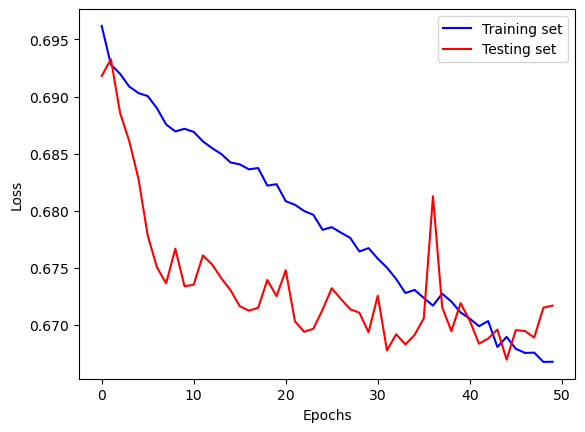

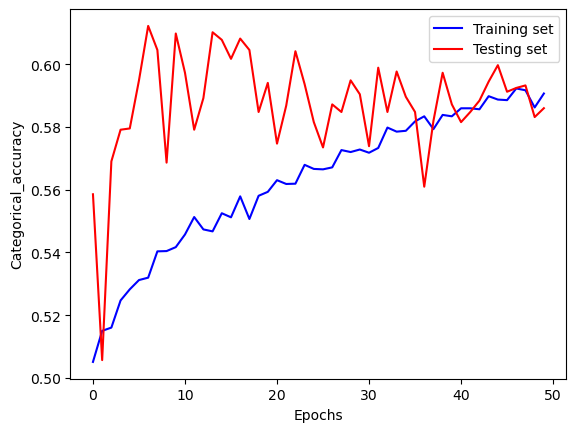

In [39]:
plot_hist_var(hist1, 'loss')
plot_hist_var(hist1, 'categorical_accuracy')

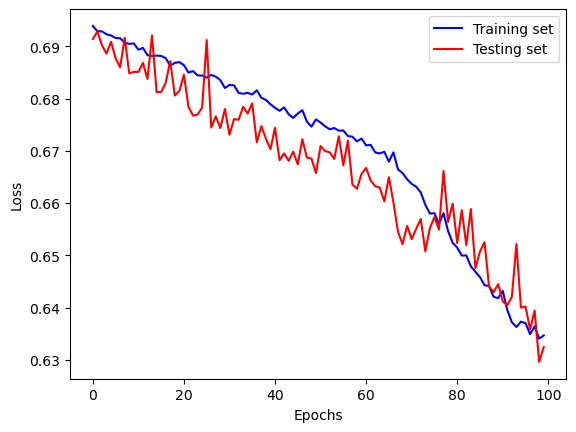

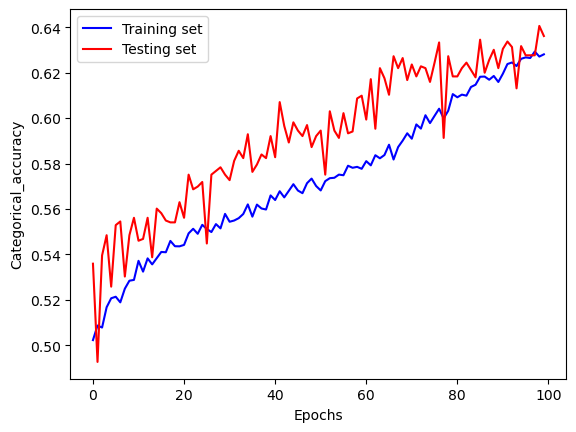

In [40]:
plot_hist_var(hist2, 'loss')
plot_hist_var(hist2, 'categorical_accuracy')